In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import os
import sys
import math
import random
import datetime

from sympy import *
from scipy import ndimage
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization,\
                                    Add, AveragePooling2D, GlobalAveragePooling2D,\
                                    Flatten, Dense, Dropout, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

projectpath = '/content/drive/My Drive/Colab Notebooks/Plant_Pathology/'
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
sys.path.append(projectpath)

# custom moduls
import prepare_img
import classifiers
import augmentation
import config
import pickle
import seaborn as sn

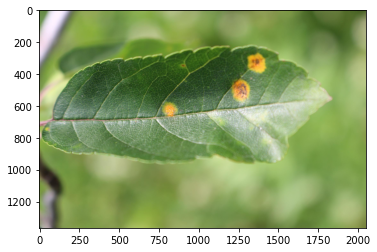

In [0]:
# example image
img_path = projectpath + 'images/train/Train_3.jpg'
img = cv2.imread(img_path)
plt.imshow(img[:,:,::-1])

In [0]:
### ImageProcessing // OpenCV ###
# This cell makes the compressed version of the original dataset, run only once 
# and then load the data from [train_compressed] folder

load_path = projectpath + 'images/train/'
save_path = projectpath + 'images/train_compressed/'

data_ids = os.listdir(load_path)
limit = len(data_ids)
img_size_desired = (400,300)

for i in range(limit):
  img0 = cv2.imread(os.path.join(load_path,data_ids[i]))

  if img0 is not None:
    if i % 10 == 0:
      print(i)

    img2,ellipse = prepare_img.FitEllipse(img0)
    img3,rectangle = prepare_img.FitRectangleInsideEllipse(img2, ellipse, img_size_desired)
    img4 = prepare_img.CropAroundRectangle(img3, rectangle, img_size_desired)
    
    #cv2.imwrite(os.path.join(save_path, data_ids[i]), img4)

In [0]:
### LOAD DATASET
# This cell loads the selected dataset in load_path, suggested to use [train_compressed]

data_path = projectpath + 'images/train_compressed/'
labels_path = projectpath + 'train.csv'

data_ids = os.listdir(data_path)
labels_table = pd.read_csv(labels_path)
imgsize = (300, 400, 3)
num_classes = 4
limit = len(data_ids)

data_x = np.zeros((len(data_ids), imgsize[0], imgsize[1], imgsize[2]), dtype='uint8')
data_y = np.zeros((len(data_ids),num_classes), dtype="uint8")

for i in range(limit):
  img0 = cv2.imread(os.path.join(load_path,data_ids[i]))

  if img0 is not None:
    if i % 100 == 0:
      print(i)

    data_x[i] = img0
    # directly convert to one hot labels
    data_y[i] = (labels_table[['healthy', 'multiple_diseases', 'rust', 'scab']].values[data_ids[i].split('.')[0] == labels_table['image_id'].values])
  else:
    print("Image Read Error")
    print(data_ids[i])


### remove faulty images
f = open(projectpath + "exclude_from_experiment.txt", 'r')
excludes = f.readlines()
excludes_vec = np.ones(len(data_ids), dtype="uint8") 
excludes_pos = []

for exclude in excludes:
  tmp = exclude.split("\n")[0]
  if "?" in tmp: # some marked with '?'
    tmp = tmp.split("?")[0]
  exclude_full = 'Train_' + tmp + '.jpg'
  for i, j in enumerate(data_ids):
      if j == exclude_full:
          excludes_vec[i] = False
          excludes_pos = np.append(excludes_pos, i)
excludes_pos = np.flip(np.sort(excludes_pos)).astype(int) # remove from the end always
excludes_vec = excludes_vec == 1  # convert to bool
data_x = data_x[excludes_vec]
data_y = data_y[excludes_vec]

In [0]:
r = config.ResNet(filters = [64, 128, 256, 512], 
              ksize = (7,7),
              strides = 2,
              pool = (3,3),
              blocks = [2, 2, 2, 2],
              outputsize = num_classes,
              inputsize = imgsize
              )

parent_path =         "/content/drive/My Drive/Colab Notebooks/Plant_Pathology/checkpoints/"
load_model_path =     "/content/drive/My Drive/Colab Notebooks/Plant_Pathology/checkpoints/ckpt/Dense121_20200507-150646_CV1/cp-0002.ckpt"
load_variable_path =  "/content/drive/My Drive/Colab Notebooks/Plant_Pathology/checkpoints/variables/Dense121_20200507-195656_CV1/pred.pckl"
predictions = np.zeros((data_y.shape))

model_flag = 2    # 0: ResNet18, 1: Densenet121 2: ResNet50
savemode_flag = 2   # 0: nothing, 1: only checkpoint, 2: only tensorboard 3: both
continue_training_from = False # CV cycle can be selected to continue the training
special_tag = '_' # special information in the saved filename

# predefined training order
num_splits = 4 
kf = KFold(n_splits=num_splits)
kf.get_n_splits(data_x)
train_idxs = []
test_idxs = []
for train_idx, test_idx in kf.split(data_x):
  train_idxs.append(train_idx)
  test_idxs.append(test_idx)


for CV in range(num_splits):

  begin = datetime.datetime.now()
  if continue_training_from:
    # loading is not used, rather start from the beginning of selected CV
    #model.load_weights(load_model_path) 
    CV = continue_training_from
    continue_training_from = False
    f = open(load_variable_path, 'rb')
    [predictions, train_idxs, test_idxs] = pickle.load(f)
    
  ### data preparation 
  train_idx = train_idxs[CV]
  test_idx = test_idxs[CV]

  # calculate mean and std over training set
  num_channels = 3
  mean = np.zeros(num_channels)
  std = np.zeros(num_channels)
  for i in range(num_channels):
    mean[i] = np.mean(data_x[train_idx,:,:,i])
    std[i] = np.std(data_x[train_idx,:,:,i])

  # apply augmentation on the training set
  train_x, train_y = augmentation.pipeline(data_x[train_idx], data_y[train_idx])
  test_x = data_x[test_idx]
  test_y = data_y[test_idx]

  # normalize full dataset with respect to the training set (not to ImageNet)
  train_x = train_x.astype(float)
  test_x = test_x.astype(float)
  for i in range(num_channels):
    train_x[:,:,:,i] = (train_x[:,:,:,i] - mean[i]) / std[i]
    test_x[:,:,:,i] = (test_x[:,:,:,i] - mean[i]) / std[i]

  # avoid running out of gpu memory between CVs
  tf.keras.backend.clear_session()

  # model selection
  if model_flag == 0: 
    model = classifiers.build_ResNet(r)
    tag = 'ResNet18_'
  elif model_flag == 1: 
    model = DenseNet121(include_top=True, 
                        weights=None, 
                        input_tensor=None, 
                        input_shape=imgsize, 
                        pooling=None, 
                        classes=num_classes)
    tag = 'Dense121_'
  elif model_flag == 2: 
    model = ResNet50(include_top=True, 
                        weights=None, 
                        input_tensor=None, 
                        input_shape=imgsize, 
                        pooling=None, 
                        classes=num_classes)
    tag = 'ResNet50_'

  # compile selected model
  model.compile(optimizer='adam',
				        loss='categorical_crossentropy',
				        metrics=['accuracy'])

  ### path for callbacks 
  timestr = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  name = tag+special_tag+timestr+'_CV'+str(CV)
  checkpoint_path = parent_path+'ckpt/'+name+"/cp-{epoch:04d}.ckpt"
  checkpoint_dir = os.path.dirname(checkpoint_path)
  os.system('mkdir {}'.format(checkpoint_dir))

  # checkpoint
  cp_callback = ModelCheckpoint(
      filepath=checkpoint_path,
      save_weights_only=True,
      verbose=1)
  
  # tensorboard
  tensorboard_callback = TensorBoard(
      log_dir= parent_path+'tensorboard_logs/'+name,
      histogram_freq=1)
  
  # saving method selection
  if savemode_flag == 0:
    savemode = False
  elif savemode_flag == 1:
    savemode = cp_callback
  elif savemode_flag == 2:
    savemode = tensorboard_callback
  elif savemode_flag == 3:
    savemode = [cp_callback, tensorboard_callback]

  # training
  history = model.fit(
      x=train_x,
      y=train_y,
      epochs=35,
      verbose=1,
      validation_data=(test_x, np.squeeze(test_y)),
      batch_size=32,
      callbacks=savemode)
  
  # summarized predictions over all CV for whole dataset
  predictions[test_idx] = model.predict(test_x)

  # save variables which are necessary to continue interrupted experiments
  os.makedirs(parent_path + 'variables/' + name + '/')
  f = open(parent_path + 'variables/' + name + '/pred.pckl', 'wb')
  pickle.dump([predictions, data_y, train_idxs, test_idxs, CV], f)
  f.close()

  f = open(parent_path + 'variables/' + name + '/hist.pckl', 'wb')
  pickle.dump(history.history, f)
  f.close()

  print("Time spent in CV cycle:", datetime.datetime.now() - begin)


All: (1782, 300, 400, 3)
Label: 0samples: 516.0
Label: 1samples: 84.0
Label: 2samples: 594.0
Label: 3samples: 588.0
[[89.92  1.55  1.74  6.78]
 [ 4.76 46.43 23.81 25.  ]
 [ 1.35  8.42 89.9   0.34]
 [ 5.95  3.23  0.68 90.14]]


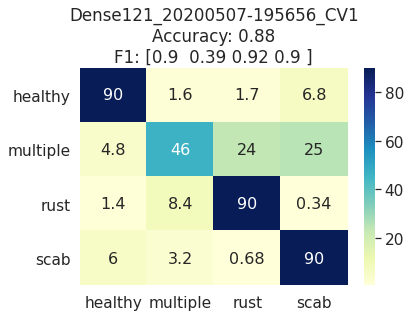

In [0]:
### load saved files
saved_preds_path = parent_path + 'variables/' + name + '/pred.pckl' 
f = open(saved_preds_path, 'rb')
[predictions, data_y, train_idxs, test_idxs, CV] = pickle.load(f)

# display results
labels_int = np.argmax(data_y, axis=1)
labels_unique = np.unique(labels_int)
labels_sum = np.zeros(len(labels_unique))

# determine which class has the most sample and the target output
for i in range(len(labels_unique)):
  label_cur = labels_unique[i]
  labels_sum[i] = sum(labels_int == label_cur)
  print("Label: " + str(label_cur) + "   samples: " + str(labels_sum[i]))

# calculate confusion matrix
cm = np.round(confusion_matrix(np.argmax(data_y, axis = 1), np.argmax(predictions, axis = 1), normalize='true')*100,2)
print(cm)
df_cm = pd.DataFrame(cm, 
                     index = ['healthy', 'multiple', 'rust', 'scab'],
                     columns= ['healthy', 'multiple', 'rust', 'scab'])

# colorize confusion matrix
pd.DataFrame()
ax = plt.axes()
sn.set(font_scale=1.4) 
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap='YlGnBu', ax = ax)

# extra information on image
acc = round(accuracy_score(np.argmax(data_y, axis = 1), np.argmax(predictions, axis = 1)),2)
f1 = f1_score(np.argmax(data_y, axis = 1), np.argmax(predictions, axis = 1), average = None)
for i in range(len(f1)):
  f1[i] = round(f1[i],2)
ax.set_title(str(saved_preds_path.split('/')[-2]) + '\n' + 'Accuracy: ' + str(acc) + '\n' + 'F1: ' + str(f1))
plt.show()